## Homework: Return Predictions From Trade Flow

========================================================================================================================

### Richmond Frankeberger 12277572 

========================================================================================================================

### Defining Data and Variables

Trade data from CoinBase Websocket API for 2021 is used to analyze the currency pair trades for BTCUSD, ETHUSD, and ETHBTC. Trading opportunities are explored, in particular with regard to the relationship between trade flow and predicted returns.

Flow $F$ will be defined as the volume bought $V^B$ vs volume sold $V^S$at any given non-unique timestamp in the data. Non-unique means that there are instances in the dataset where separate trades appear with the same exact timestamp.

$F_t^{(\tau)} = V_{(t-\tau,t)}^B - V_{(t-\tau,t)}^S$

where $\tau$ is the time interval for the observation starting at $t$, a given point in time.

Returns will be calculated on a logarithmic basis:

$r_t^{(T)} = \log \left( \frac{P_t}{P_{(t-T)}}\right)$

where $T$ is the backward looking time at which a return is realized at $t$ for the interval $T$ to $t$, and $P$ are the prices at the given time intervals.

$P_t$ is calculated as the last observed price at $t$.

$P_{t-T}$ will be the **weighted average** of prices from $t-T$ to but not including $t$.

========================================================================================================================

#### Imports, Functions, and Data Download

In [141]:
%matplotlib inline
import pandas                    as     pd
import numpy                     as     np
import seaborn                   as     sns
import statsmodels.api           as     sm
import scipy
import sys
import requests
import time
import pytz
from   matplotlib                import pyplot as plt
from   datetime                  import datetime
from   datetime                  import timedelta
from   p_tqdm                    import p_map,t_map
from   tqdm.notebook             import tqdm
from   os.path                   import exists  

In [824]:
### download book or trade data from local files.
### Arguments: filetype: book/trades, pair: trading pair, year: data year, adj_tz: Toggle UCT vs CST
def get_data(filetype: str, pair: str, year: str, adj_tz = "no"):
    
    if filetype   == "trades":
        filename  = f"trades_narrow_{pair}_{year}.delim.gz"
    elif filetype == 'book':
        filename  = f"book_narrow_{pair}_{year}.delim.gz"
        
    df            = pd.read_csv(f"{filename}", delimiter="\t")
    localtime     = pytz.timezone("US/Central")
    df.timestamp_utc_nanoseconds = pd.to_datetime(df.timestamp_utc_nanoseconds)
    df            = df.set_index("timestamp_utc_nanoseconds")
    if adj_tz     == "yes":
        df.index  = df.index.tz_localize(pytz.utc).tz_convert(localtime)
    df = df.drop(columns=df.columns[df.columns.str.contains("received_utc_nanoseconds")])
    return df

### Calculate major statistics for the test dataset, such as Alpha, Beta, R-squared, OOS R-squared
def AnalyzeStats(y_train,x_train,y_test,x_test):
    x                    = x_train / 1000000000
    myx                  = sm.add_constant(x)
    myxtest              = sm.add_constant(x_test / 1000000000)
    OLS                  = sm.OLS(y_train,myx,missing='drop').fit()
    pred                 = OLS.predict(myxtest)
    forecasterror        = y_test - pred
    nullforecast         = y_test - y_test.mean()
    OOSR2_num            = (forecasterror ** 2).sum()
    OOSR2_dem            = (nullforecast ** 2).sum()
    OOSR2                = 1 - OOSR2_num/OOSR2_dem
    
    df_ret               = pd.DataFrame(index=['Strat_Ret'],columns=['Alpha','Beta'])
    df_ret['Alpha']      = OLS.params['const']
    df_ret['Beta']       = OLS.params[1]
    df_ret[r'$R^2$']     = OLS.rsquared
    
    df_ret[r'OOS $R^2$'] = OOSR2
    
    return df_ret

### For this strategy - apply no annualization given the extremely small increments, and evaluate locally only.
def performanceMetrics(returns, annualization = 1):
    df = returns.copy()
    q = 0.05
    metrics            = pd.DataFrame(index=returns.columns)
    metrics['Mean']    = returns.mean() * annualization
    metrics['Vol']     = returns.std() * np.sqrt(annualization)
    metrics['Sharpe']  = (returns.mean() / returns.std()) * np.sqrt(annualization)
    metrics['Sortino'] = (returns.mean() / returns[returns < 0].std()) * np.sqrt(annualization)
    metrics['Min']     = returns.min()
    metrics['Max']     = returns.max()
    metrics.sort_values('Sharpe',ascending = False)
    
    # return metrics
    
    report = pd.DataFrame(columns = df.columns)
    
    #report.loc['Skewness'] = df.skew()
    #report.loc['Excess Kurtosis'] = df.kurtosis()
    #report.loc['VaR (Quantile {})'.format(q)] = df.quantile(q)
    #report.loc['VaR (Normal)'] = df.mean() + scipy.stats.norm().ppf(q) * df.std()
    #report.loc['Expected Shortfall'] = df[df < df.quantile(q)].mean()
    #report.loc['Expected Shortfall (Normal)'] = df.mean() - scipy.stats.norm.pdf((scipy.stats.norm().ppf(q)))/q * df.std()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    
    """report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None
    """
    return pd.concat([metrics,report.T],1)

def train_tau(trades,books,pair,tau,T,usebooks = "no",stratstats = "no",predstats = "no", capital = 1000000, trade = 10,warnings = True):
    
    ### Check if file exists already
    if not exists("{}_tau_{}_T_{}_seconds.csv".format(pair,tau,T)):
    
        if usebooks    == "yes":
            df_full    = pd.merge_asof(trades,books,on ='timestamp_utc_nanoseconds').dropna()
        else:
            df_full    = trades
        
        ### Calculate the Cumulative flow
        df_full2       = df_full.copy()
        df_full        = df_full.assign(Flow = (df_full['SizeBillionths'] * (df_full['Side'] < 0 )\
                                             - df_full['SizeBillionths']  * (df_full['Side'] > 0 )).cumsum())
        
        ### Calculate the flow per non-unique timestamp
        df_full_shift       = df_full.copy()
        df_full_shift.index = df_full_shift.index             + timedelta(seconds = tau)
        df_concat           = pd.concat([df_full['Flow'].to_frame('Flow_tau_end'),df_full_shift['Flow'].to_frame('Flow_start')],0)
        df_concat           = df_concat.sort_index(kind='stable').fillna(method='ffill')
        df_concat           = df_concat.assign(Flow           = df_concat['Flow_tau_end'] - df_concat['Flow_start'])
        
        df_merged           = pd.merge_asof(df_full2,df_concat,left_index=True,right_index=True)
        
        ### Redefine T in timedelta terms
        Ret_T               = timedelta(seconds = T)
        
        ### Calculate the weighted average from t to tau, without including point t
        df_wa_test          = df_merged.copy()[['PriceMillionths','SizeBillionths']]
        df_wa_test          = df_wa_test.assign(dolvol        = df_wa_test['PriceMillionths'] / 1000000000 * df_wa_test['SizeBillionths'])
        df_wa_test          = df_wa_test.groupby(df_wa_test.index).agg('sum')
        
        df_wa_test          = df_wa_test.assign(WeightPx      = df_wa_test['dolvol'] / df_wa_test['SizeBillionths'] * 1000000000)
        df_wa_test          = df_wa_test[['WeightPx']]
        df_wa_test          = df_wa_test.assign(WeightPxStart = df_wa_test['WeightPx'].rolling('{}s'.format(T),closed='left').mean().ffill())
        
        ### Calculate returns per non-unique timestamp, and return a csv
        df_to_csv           = pd.merge_asof(df_merged,df_wa_test,left_index=True,right_index=True)
        df_to_csv           = df_to_csv.assign(Ret            = df_to_csv['PriceMillionths'] / df_to_csv['WeightPxStart'] - 1)
        df_to_csv           = df_to_csv.reset_index()
        df_to_csv           = df_to_csv[['timestamp_utc_nanoseconds','Flow','Ret']]
        filename            = "{}_tau_{}_T_{}_seconds.csv".format(pair,tau,T)

        df_to_csv.to_csv(filename)
        #display(df_to_csv)

    else:
        if warnings         == True:
            print("The file exists already!")
    
    ### Given the short timeframe and it is hard to assess a mean, the regression will include an intercept
    df_results  = pd.read_csv("{}_tau_{}_T_{}_seconds.csv".format(pair,tau,T))
    df_train    = df_results.iloc[:int(df_results.shape[0] * 0.2),:]
    df_test     = df_results.iloc[int(df_results.shape[0] * 0.2):,:]

    ### Train the dataset    
    train_stats = AnalyzeStats(df_train['Ret'],df_train['Flow'],df_test['Ret'],df_test['Flow'])
    
    ### Parameters for Testing
    df_test     = df_test.assign(Pred_Ret      = df_test['Flow']              / 1000000000         * train_stats['Beta'][0] + train_stats['Alpha'][0])
    df_test     = df_test.assign(j_h           = df_test['Pred_Ret'].mean()   + df_test['Pred_Ret'].std())
    df_test     = df_test.assign(j_l           = df_test['Pred_Ret'].mean()   - df_test['Pred_Ret'].std())
    j_h         = df_test['Pred_Ret'].mean()   + df_test['Pred_Ret'].std()
    j_l         = df_test['Pred_Ret'].mean()   - df_test['Pred_Ret'].std()

    ### Calculate PL and Test
    ### The code below assumes you can make a new trade at every non-unique timestamp, which is only realistic if you trade extremely small amounts per capital
    ### Otherwise, bounds on quantity size would need to be implemented, which also means that you could only enter the best opportunity present at any given time; this would complicate return calcs.
    df_test     = df_test.assign(Position = (df_test['Pred_Ret'] > df_test['j_h'])  * 1     - (df_test['Pred_Ret'] < df_test['j_l']) * 1)
    df_test     = df_test.assign(PL_DLY   = (df_test['Position']  * (df_test['Ret']) * trade))
    df_test     = df_test.assign(PL_LTD   = df_test['PL_DLY'].cumsum())

    df_test     = df_test.set_index("timestamp_utc_nanoseconds")

    if stratstats == "yes":
        df_test =  df_test.assign(Strat_Ret = (df_test['PL_DLY'])/(df_test['PL_LTD']+capital))
        df_perf = performanceMetrics(df_test[['Strat_Ret']])
        df_perf = df_perf.assign(PL_LTD     = df_test['PL_LTD'][-1])
        results = df_perf.join(train_stats).T
        return results
    
    elif predstats == "yes":
        df_pred_power                           = pd.DataFrame(index = ['Strat_Ret'], columns = [r'Act $\sigma$',r'Pred $\sigma$'])
        #df_pred_power['rows']                  = df_test.shape[0]
        df_pred_power['Pred > j_h %']           = df_test[df_test['Pred_Ret'] > df_test['j_h']].count()[0] / df_test.shape[0]
        df_pred_power['Pred < j_l %']           = df_test[df_test['Pred_Ret'] < df_test['j_l']].count()[0] / df_test.shape[0]
        df_pred_power['j_h']                    = df_test['j_h'][0]
        df_pred_power['j_l']                    = df_test['j_l'][0]
        df_pred_power[r'Act $\sigma$']          = df_test['Ret'].std()
        df_pred_power[r'Pred $\sigma$']         = df_test['Pred_Ret'].std()
        df_pred_power['Act_Skew']               = df_test['Ret'].skew()
        df_pred_power['Act_Kurtosis']           = df_test['Ret'].kurtosis()
        df_pred_power['Pred Neg. Miss Rate %']  = df_test[((df_test['Pred_Ret'] < 0) & (df_test['Ret'] > 0)) | ((df_test['Pred_Ret'] > 0) & (df_test['Ret'] < 0))].shape[0] /df_test.shape[0]
        results                                 = df_pred_power.join(train_stats).T
        return results
    
    return df_train, df_test


def optimal_j(trades,books,pair,tau,T,capitalamt = 1000000, tradeamt = 10):
    train,test = train_tau(trades,books,pair,tau,T,usebooks = "no",stratstats = "no",predstats = "no", capital = capitalamt, trade = tradeamt,warnings = False)
    df_table = pd.DataFrame(index=['PL_LTD','Sharpe'])
    for j in tqdm(np.arange(0,max(abs(test['j_h'][0]),abs(test['j_l'][0]))*3,0.00005)):
        opt      = test.copy()[['Pred_Ret','Ret']]
        opt      = opt.assign(Position_opt = np.where((opt['Pred_Ret'] > j),1,np.where((opt['Pred_Ret'] < -j),-1,0)))
        opt      = opt.assign(Pos_Ret      = (opt['Position_opt'] * opt['Ret']))
        opt      = opt.assign(PL_DLY       = opt['Position_opt']  * (opt['Ret']) * tradeamt)
        df_table['{}'.format(j)] = opt['PL_DLY'].cumsum()[-1]
        df_table.loc['Sharpe','{}'.format(j)] = opt['Pos_Ret'].mean() / opt['Pos_Ret'].std()

    return df_table

def plot_returns(returns,pair,dtype):
    dist = sns.displot(returns['Ret'],kde=True,height = 6,aspect = 2)
    dist.fig.set_dpi(80)
    plt.axvline(0, c='lightskyblue')
    plt.title("Distribution of Actual {} Returns for {}".format(dtype,pair))
    plt.show()
    
def plot_predreturns(returns,pair):
    dist = sns.displot(returns['Pred_Ret'],kde=True,height = 6,aspect = 2)
    dist.fig.set_dpi(80)
    plt.axvline(0, c='lightskyblue')
    plt.title("Distribution of Predicted Test Returns for {}".format(pair))
    plt.show()

In [41]:
pd.options.display.float_format = '{:.7f}'.format

In [346]:
BTCUSD_trades = get_data("trades","BTC-USD","2021","yes")
BTCUSD_book   = get_data("book"  ,"BTC-USD","2021","yes")
ETHUSD_trades = get_data("trades","ETH-USD","2021","no")
ETHBTC_trades = get_data("trades","ETH-BTC","2021","no")

### Exercise and Analysis

The strategy will be set to trade whenever it predicts that there's going to be a return that is volatile compared to the average returns. Specifically, $j$ will initially be set to a level of one standard deviation $\sigma$ away from the mean of predicted returns $\hat{r}_i$. Given the means won't necessarily be zero, this means that for this analysis, there will be two $j$'s: $j_h$ and $j_l$. When the predicted return $\hat{r}_i$ is greater than $j_h$, buy the pair (buy numerator, short denominator), and then sell at T. When the predicted return $\hat{r}_i$ is less than $j_{l}$, sell the pair, i.e do the opposite. The mean and vol will be based on the training dataset as well. 

The optimization of $j$ will be done only after defining the optimal parameters of tau and T. Tau and T are inputs for flow and returns respectively, and it's important to optimize the relationship between them first before optimizing any particular trading strategy. Therefore, the optimization of $j$ will only be done once per currency for the best performing strategy.

For ease of calculation, $j$ will be explored in a bound of anywhere from 0 to 3 standard deviations away from the mean, under the assumption that $j$ was calculated as one standard deviation from a mean of zero. The exploration will be done in increments of half a bp, given initial observations across strategies for BTCUSD had values anywhere from zero to 5 bps.

The first step for evaluating this strategy will be to check what values of tau and T are most profitable to trade. Tau and T will be chosen from combinations of 1, 2, 10, 30, and 60 seconds. These timeframes were chosen based on what the professor mentioned in class; specifically, the professor mentioned that a generally good timeframe for tau or T would be anywhere from half a second to sixty seconds. Given the computer being used for this analysis is not industrially competitive, the analysis has been done on a conservative basis of including 1 second as the bottom range, and up to 60 seconds for the top range. For ease, the 1-60 range is being based on the exchange timestamps - i.e. the calculations are not explicitly assuming latency. However by bounding to a high lower bound, this will make any high frequency trading opportunities relatively viable with this computer. (for example, finding a strategy that works in 0.2 second intervals would be impossible on this machine, but a 2 second interval strategy that is a magnitude of 10 higher could be executable even with 0.x lagtime.)

Although calculating PL in terms of an executable strategy is extremely difficult given the market impact one can have on the market in doing trades, assessing whether a level is realistically executable at a given time etc., this analysis naively calculates PL by using a very conservative portfolio approach. The objective of this is to get an idea of a "gross" performance ratio, before fees/costs/lag. To do this, Capital of \\$1m is assumed, and each trade is entered at a very low and relatively easy to enter amount of $10.

Specific analysis on each pair is done below. The optimal tau and T are highlighted, along with other interesting statistical and performance analytics.

In [756]:
tau_list = [1,2,10,30,60]
T_list   = [1,2,10,30,60]

In [854]:
### Function to evaluate strategy performance for multiple intervals at a time.
def evaluate(trades,pair,tau_list,t_list,book=None,usebook="no",strat="no",pred="no",warning_mask=True):
    concatlist = []
    for tau in tqdm(tau_list):
        for T in t_list:
            stats = train_tau(trades,book,pair,tau,T,usebook,stratstats=strat,predstats=pred,warnings=warning_mask)
            stats = stats.rename(columns={'Strat_Ret':'{}_tau_{}_T_{}'.format(pair,tau,T)})
            concatlist.append(stats)
    return pd.concat(concatlist,1).T

### BTCUSD

#### Strategy Comparison

The below table shows that $\tau=30,T=60$ are the optimal parameters for BTCUSD in terms of out of sample R-squared. The Sharpe and Sortino ratios for the strategy are also the highest here, and the maximum drawdown is only the third worst in the population. PL is maximimzed as well. Alpha is negative - there are other strategies with positive alpha, but the R-Squared for them are much lower, such as $\tau=1,T=30$.

In [757]:
BTCUSD_perf_table = evaluate(BTCUSD_trades,"BTCUSD",tau_list,T_list,strat="yes",warning_mask=False)

  0%|          | 0/5 [00:00<?, ?it/s]

##### Top/Bottom Strategies

In [850]:
BTCUSD_perf_table.sort_values(f'OOS $R^2$',ascending = False).head(10)

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,PL_LTD,Alpha,Beta,$R^2$,OOS $R^2$
BTCUSD_tau_30_T_60,0.0000000,0.0000000,0.1440549,0.0866166,-0.0000002,0.0000004,-0.0001443,9587.3694764,-0.0000097,-0.0000328,0.2513030,0.2861363
BTCUSD_tau_60_T_60,0.0000000,0.0000000,0.1178061,0.0579163,-0.0000002,0.0000004,-0.0002934,7726.3877343,-0.0000126,-0.0000201,0.1973395,0.2555363
BTCUSD_tau_30_T_30,0.0000000,0.0000000,0.1252885,0.0667978,-0.0000002,0.0000003,-0.0001113,5783.8134815,-0.0000061,-0.0000219,0.2166684,0.2362029
BTCUSD_tau_10_T_30,0.0000000,0.0000000,0.1380100,0.0898528,-0.0000001,0.0000003,-0.0001012,6264.2010452,-0.0000021,-0.0000411,0.2316591,0.2196707
BTCUSD_tau_1_T_2,0.0000000,0.0000000,0.0700470,0.0650968,-0.0000002,0.0000003,-0.0000023,1990.0216731,-0.0000007,-0.0000343,0.2539629,0.2059923
BTCUSD_tau_10_T_60,0.0000000,0.0000000,0.1353042,0.0777536,-0.0000002,0.0000004,-0.0001701,8745.1150853,-0.0000026,-0.0000531,0.2009390,0.1967505
BTCUSD_tau_2_T_10,0.0000000,0.0000000,0.0945267,0.0735448,-0.0000001,0.0000003,-0.0000144,2975.1713001,-0.0000003,-0.0000434,0.1763113,0.1934816
BTCUSD_tau_1_T_1,0.0000000,0.0000000,0.0650283,0.0507978,-0.0000002,0.0000003,-0.0000023,1831.8618037,-0.0000006,-0.0000308,0.2748766,0.1926531
BTCUSD_tau_1_T_10,0.0000000,0.0000000,0.0824457,0.0575576,-0.0000002,0.0000003,-0.0000088,2531.4078303,0.0000002,-0.0000459,0.1419187,0.1829276
BTCUSD_tau_2_T_2,0.0000000,0.0000000,0.0731454,0.0586491,-0.0000001,0.0000003,-0.0000037,2081.7579549,-0.0000010,-0.0000292,0.2563666,0.1816310


In [851]:
BTCUSD_perf_table.sort_values(f'OOS $R^2$',ascending = False).tail(10)

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,PL_LTD,Alpha,Beta,$R^2$,OOS $R^2$
BTCUSD_tau_2_T_60,0.0000000,0.0000000,0.0998014,0.0558514,-0.0000001,0.0000004,-0.0000370,5483.5330108,0.0000033,-0.0000728,0.0938827,0.1028549
BTCUSD_tau_2_T_30,0.0000000,0.0000000,0.1144552,0.0666501,-0.0000001,0.0000003,-0.0000332,2745.2476081,0.0000092,-0.0000502,0.1402980,0.0832348
BTCUSD_tau_60_T_10,0.0000000,0.0000000,0.0638751,0.0383578,-0.0000002,0.0000003,-0.0001077,2058.6979679,-0.0000035,-0.0000047,0.0573399,0.0822907
BTCUSD_tau_1_T_60,0.0000000,0.0000000,0.0878018,0.0450522,-0.0000002,0.0000004,-0.0000319,4336.5597183,0.0000041,-0.0000728,0.0676211,0.0821833
BTCUSD_tau_10_T_2,0.0000000,0.0000000,0.0646313,0.0611935,-0.0000001,0.0000003,-0.0000089,1862.2732202,-0.0000018,-0.0000105,0.1316810,0.0783924
BTCUSD_tau_10_T_1,0.0000000,0.0000000,0.0578294,0.0554684,-0.0000002,0.0000003,-0.0000060,1643.2183998,-0.0000015,-0.0000085,0.1158917,0.0634188
BTCUSD_tau_30_T_2,0.0000000,0.0000000,0.0536231,0.0436966,-0.0000002,0.0000003,-0.0000217,1546.9766958,-0.0000022,-0.0000040,0.0646535,0.0512472
BTCUSD_tau_30_T_1,0.0000000,0.0000000,0.0495279,0.0416859,-0.0000002,0.0000003,-0.0000173,1408.8465484,-0.0000017,-0.0000033,0.0575433,0.0418013
BTCUSD_tau_60_T_2,0.0000000,0.0000000,0.0462335,0.0367579,-0.0000002,0.0000003,-0.0000339,1309.4672328,-0.0000020,-0.0000019,0.0292750,0.0382645
BTCUSD_tau_60_T_1,0.0000000,0.0000000,0.0436559,0.0357191,-0.0000002,0.0000003,-0.0000238,1217.9166641,-0.0000016,-0.0000015,0.0260742,0.0317775


##### Best/Worst Intervals

The best $\tau - T$ combination (note this is not on the trading strategy, but purely the actual returns based on the given increments) has the lowest kurtosis of all of the other strategies. Skew is negative, and the "Pred Neg. Miss Rate %", or the percentage of times that the prediction return is in the opposite direction of the actual return, is off only 32% of the time. In a sense, the top strategy seems to be balanced in terms of all of these parameters.

Another notable strategy is $\tau=2, T=30$ which has almost no skew and relatively low kurtosis. Although it looks to exhibit somewhat "normal" distribution, if cross-checked with the table above, it's maximum drawdown is not exceptionally low at 0.30bps, and OOS R-squared is only 8%.

In [759]:
BTCUSD_pred_table = evaluate(BTCUSD_trades,"BTCUSD",tau_list,T_list,BTCUSD_book,usebook="no",strat="no",pred="yes",warning_mask = False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [852]:
BTCUSD_pred_table.sort_values(f'OOS $R^2$',ascending = False).head(10)

,Act $\sigma$,Pred $\sigma$,Pred > j_h %,Pred < j_l %,j_h,j_l,Act_Skew,Act_Kurtosis,Pred Neg. Miss Rate %,Alpha,Beta,$R^2$,OOS $R^2$
BTCUSD_tau_30_T_60,0.0016617,0.0005800,0.0338123,0.0422646,0.0005350,-0.0006249,-2.1900363,56.6885941,0.3232893,-0.0000097,-0.0000328,0.2513030,0.2861363
BTCUSD_tau_60_T_60,0.0016617,0.0005801,0.0310584,0.0398353,0.0005314,-0.0006287,-2.1900363,56.6885941,0.3446518,-0.0000126,-0.0000201,0.1973395,0.2555363
BTCUSD_tau_30_T_30,0.0011544,0.0003877,0.0338123,0.0422646,0.0003580,-0.0004173,-2.7932764,90.9117287,0.3402606,-0.0000061,-0.0000219,0.2166684,0.2362029
BTCUSD_tau_10_T_30,0.0011544,0.0003790,0.0328759,0.0391165,0.0003550,-0.0004030,-2.7932764,90.9117287,0.3359741,-0.0000021,-0.0000411,0.2316591,0.2196707
BTCUSD_tau_1_T_2,0.0006166,0.0001486,0.0173256,0.0242054,0.0001406,-0.0001565,-16.8365762,738.3946670,0.3274558,-0.0000007,-0.0000343,0.2539629,0.2059923
BTCUSD_tau_10_T_60,0.0016617,0.0004903,0.0328759,0.0391165,0.0004594,-0.0005212,-2.1900363,56.6885941,0.3569597,-0.0000026,-0.0000531,0.2009390,0.1967505
BTCUSD_tau_2_T_10,0.0007770,0.0002183,0.0216906,0.0284784,0.0002066,-0.0002300,-8.0350479,308.5966948,0.3561062,-0.0000003,-0.0000434,0.1763113,0.1934816
BTCUSD_tau_1_T_1,0.0005974,0.0001337,0.0173256,0.0242054,0.0001266,-0.0001408,-18.3014170,836.8502373,0.3033335,-0.0000006,-0.0000308,0.2748766,0.1926531
BTCUSD_tau_1_T_10,0.0007770,0.0001990,0.0173256,0.0242054,0.0001895,-0.0002086,-8.0350479,308.5966948,0.3726272,0.0000002,-0.0000459,0.1419187,0.1829276
BTCUSD_tau_2_T_2,0.0006166,0.0001468,0.0216906,0.0284784,0.0001382,-0.0001555,-16.8365762,738.3946670,0.3228794,-0.0000010,-0.0000292,0.2563666,0.1816310


In [853]:
BTCUSD_pred_table.sort_values(f'OOS $R^2$',ascending = False).tail(10)

,Act $\sigma$,Pred $\sigma$,Pred > j_h %,Pred < j_l %,j_h,j_l,Act_Skew,Act_Kurtosis,Pred Neg. Miss Rate %,Alpha,Beta,$R^2$,OOS $R^2$
BTCUSD_tau_2_T_60,0.0016617,0.0003658,0.0216906,0.0284784,0.0003500,-0.0003815,-2.1900363,56.6885941,0.4156621,0.0000033,-0.0000728,0.0938827,0.1028549
BTCUSD_tau_2_T_30,0.0011701,0.0001964,0.0295916,0.0362615,0.0001979,-0.0001948,0.2034793,62.2542567,0.4104041,0.0000092,-0.0000502,0.1402980,0.0832348
BTCUSD_tau_60_T_10,0.0007770,0.0001362,0.0310584,0.0398353,0.0001242,-0.0001481,-8.0350479,308.5966948,0.4171056,-0.0000035,-0.0000047,0.0573399,0.0822907
BTCUSD_tau_1_T_60,0.0016617,0.0003155,0.0173256,0.0242054,0.0003042,-0.0003268,-2.1900363,56.6885941,0.4320041,0.0000041,-0.0000728,0.0676211,0.0821833
BTCUSD_tau_10_T_2,0.0006166,0.0000964,0.0328759,0.0391165,0.0000890,-0.0001038,-16.8365762,738.3946670,0.3724853,-0.0000018,-0.0000105,0.1316810,0.0783924
BTCUSD_tau_10_T_1,0.0005974,0.0000782,0.0328759,0.0391165,0.0000723,-0.0000842,-18.3014170,836.8502373,0.3583243,-0.0000015,-0.0000085,0.1158917,0.0634188
BTCUSD_tau_30_T_2,0.0006166,0.0000715,0.0338123,0.0422646,0.0000650,-0.0000780,-16.8365762,738.3946670,0.4061350,-0.0000022,-0.0000040,0.0646535,0.0512472
BTCUSD_tau_30_T_1,0.0005974,0.0000583,0.0338123,0.0422646,0.0000530,-0.0000636,-18.3014170,836.8502373,0.3857967,-0.0000017,-0.0000033,0.0575433,0.0418013
BTCUSD_tau_60_T_2,0.0006166,0.0000543,0.0310584,0.0398353,0.0000489,-0.0000596,-16.8365762,738.3946670,0.4202453,-0.0000020,-0.0000019,0.0292750,0.0382645
BTCUSD_tau_60_T_1,0.0005974,0.0000443,0.0310584,0.0398353,0.0000400,-0.0000487,-18.3014170,836.8502373,0.3976307,-0.0000016,-0.0000015,0.0260742,0.0317775


#### Optimization of $j$

Given the parameters of $\tau$, $T$, and the currency pair are set, $j$ can be optimized simply by observing what level earns the most PL given the initially set levels of \\$1m capital and \\$10 per trade.

The below optimization shows that $j$ yields the best returns are achieved at zero. This should be expected because if it is assumed that one can enter at any time without any opportunity cost (foregoing entering at a later time), then it is best to enter close to infinite times. $j$ will become sensitive to how often we can enter the position. This also means that declaring an optimal $j$ will be somewhat arbitrary, because it would be completely dependent on one's computational potential as well as depth of capital.

Therefore, rather than looking at the absolute value of $j$ itself, **it is better to look at PL and Performance decay with $j$.** This way, when comparing payoffs for different currency pairs, one can decide which pair is "cheaper" to enter in the medium to long term, as one adjusts such factors related to fixed costs such as hardware/internet connection/capital and investors.

In [761]:
BTCUSD_maxj = optimal_j(BTCUSD_trades,BTCUSD_book,'BTCUSD',30,60)

  0%|          | 0/38 [00:00<?, ?it/s]

In [762]:
BTCUSD_maxj = BTCUSD_maxj.T
BTCUSD_maxj['Sharpe_diff'] = BTCUSD_maxj['Sharpe'].diff()

In [763]:
BTCUSD_maxj.sort_values('Sharpe',ascending=False)[:5]

,PL_LTD,Sharpe,Sharpe_diff
0.0,24384.5511669,0.3058656,NaN
5e-05,22560.7755039,0.2919016,-0.0139640
0.0001,20214.4697983,0.2670120,-0.0248895
0.00015000000000000001,18192.5948691,0.2446559,-0.0223562
0.0002,16438.6765356,0.2246970,-0.0199588


In [764]:
BTCUSD_maxj_worst = optimal_j(BTCUSD_trades,BTCUSD_book,'BTCUSD',60,2)

  0%|          | 0/4 [00:00<?, ?it/s]

In [765]:
BTCUSD_maxj_worst.T.sort_values('PL_LTD',ascending=False)[:5]

,PL_LTD,Sharpe
0.0,2414.3773923,0.0782652
5e-05,1361.1959862,0.0479137
0.0001,1060.4517659,0.0386573
0.00015000000000000001,991.8946108,0.0366439


##### Distribution of Returns for the Best Strategy

Finally, for visual presentation, the distribution of returns for the training dataset, testing dataset, and predicted returns of the strategy are shown below. (As well be down for ETHUSD and BTCETH).

In [828]:
BTCUSD_train, BTCUSD_test = train_tau([BTCUSD_trades],[BTCUSD_book],'BTCUSD',30,60,warnings="False")

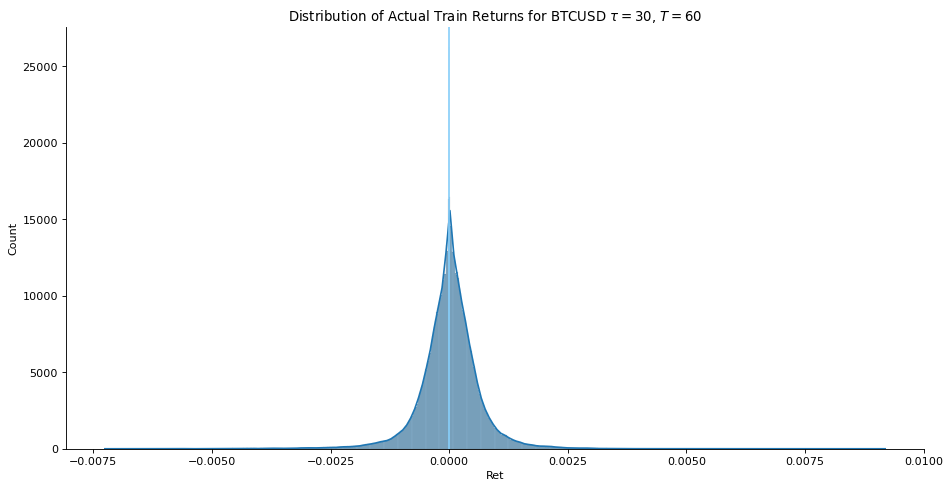

In [833]:
plot_returns(BTCUSD_train,r'BTCUSD $\tau=30$, $T=60$','Train')

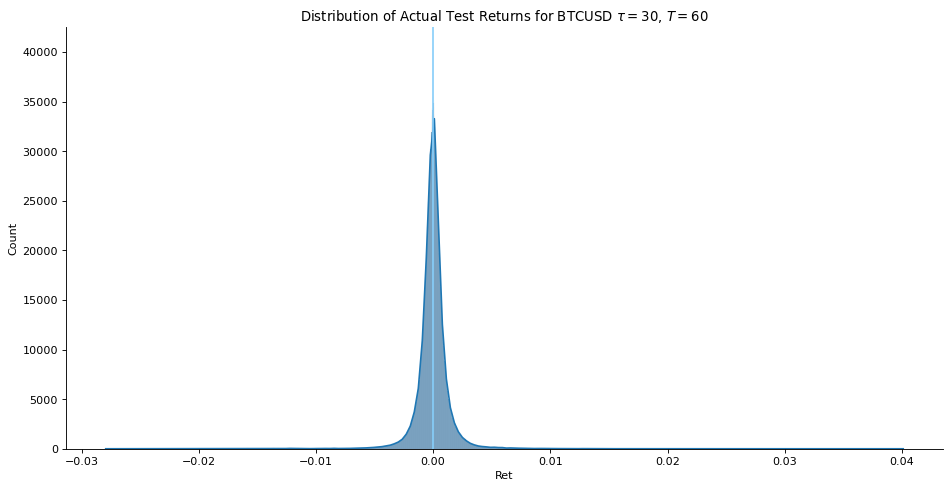

In [832]:
plot_returns(BTCUSD_test,r'BTCUSD $\tau=30$, $T=60$','Test')

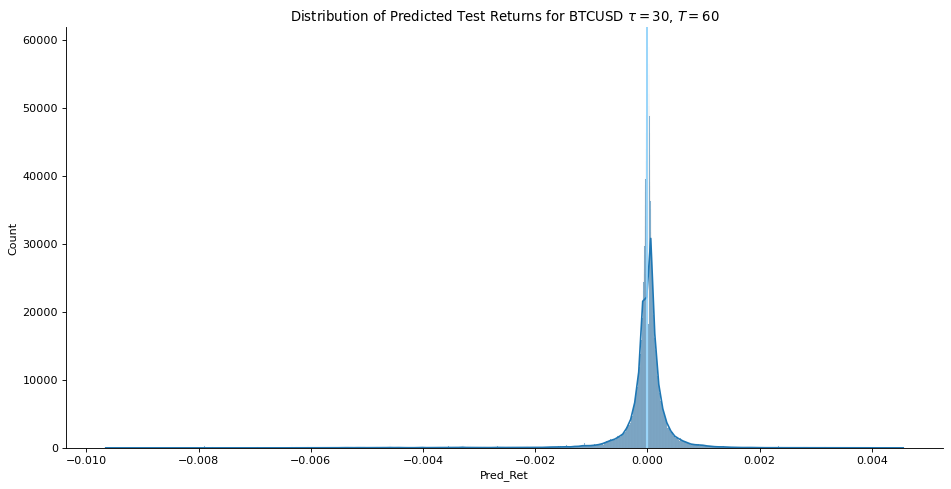

In [831]:
plot_predreturns(BTCUSD_test[(BTCUSD_test['Pred_Ret'] > 0.00002) | (BTCUSD_test['Pred_Ret'] < -0.00002)],r'BTCUSD $\tau=30$, $T=60$')

### ETHUSD

#### Strategy Comparison

Although the predictive power (out of sample r-squared) isn't as high compared to the models for BTCUSD, the optimal strategy for ETHUSD of $\tau = 2, T=2$ actually has a very small but positive alpha. If one is to believe that the relationship between flow and predicted returns is explained only by flow, then ETHUSD offers a premium return which can be realized in such a trading strategy. The absolute PL in the simulation is only \\$33 - very small compared to the close to $10k that was seen in BTCUSD - so choosing one pair/strategy over the other will depend on which statistical factors one wants to prioritize - better out of sample r-squared/predictive power in BTCUSD with larger absolute PL in simulations, or relatively low out of sample r-squared with some alpha on a small simulated PL of \\$33 on ETHUSD where the Sortino ratio is also higher at 13%.

In [766]:
ETHUSD_perf_table = evaluate(ETHUSD_trades,"ETHUSD",tau_list,T_list,strat="yes",warning_mask=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [767]:
ETHUSD_pred_table = evaluate(ETHUSD_trades,"ETHUSD",tau_list,T_list,pred="yes",warning_mask=False)

  0%|          | 0/5 [00:00<?, ?it/s]

##### Top/Bottom Strategies

In [844]:
ETHUSD_perf_table.sort_values(r'OOS $R^2$',ascending=False).head()

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,PL_LTD,Alpha,Beta,$R^2$,OOS $R^2$
ETHUSD_tau_2_T_2,0.0000000,0.0000000,0.1309595,0.1285639,-0.0000000,0.0000000,-0.0000001,33.6354060,0.0000005,-0.0000021,0.1760527,0.2187247
ETHUSD_tau_1_T_2,0.0000000,0.0000000,0.1249630,0.1113547,-0.0000000,0.0000000,-0.0000001,31.2442602,0.0000004,-0.0000021,0.1688309,0.2119545
ETHUSD_tau_1_T_1,0.0000000,0.0000000,0.1207274,0.1024796,-0.0000000,0.0000000,-0.0000001,29.1638948,-0.0000002,-0.0000020,0.1516536,0.2092638
ETHUSD_tau_2_T_1,0.0000000,0.0000000,0.1228493,0.1089731,-0.0000000,0.0000000,-0.0000001,29.7543167,-0.0000002,-0.0000019,0.1497011,0.1983892
ETHUSD_tau_30_T_60,0.0000000,0.0000000,0.1849675,0.1699846,-0.0000000,0.0000001,-0.0000014,162.0909503,0.0000181,-0.0000029,0.1011277,0.1741503


In [845]:
ETHUSD_perf_table.sort_values(r'OOS $R^2$',ascending=False).tail()

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,PL_LTD,Alpha,Beta,$R^2$,OOS $R^2$
ETHUSD_tau_1_T_30,0.0000000,0.0000000,0.1115507,0.0451126,-0.0000000,0.0000000,-0.0000007,50.8224213,0.0000049,-0.0000025,0.0427129,0.0559250
ETHUSD_tau_60_T_2,0.0000000,0.0000000,0.0956482,0.0670664,-0.0000000,0.0000000,-0.0000005,25.2783835,-0.0000011,-0.0000004,0.0380207,0.0541149
ETHUSD_tau_2_T_60,0.0000000,0.0000000,0.1160614,0.0492589,-0.0000000,0.0000001,-0.0000011,71.9439032,0.0000136,-0.0000030,0.0344980,0.0513232
ETHUSD_tau_60_T_1,0.0000000,0.0000000,0.0902270,0.0674536,-0.0000000,0.0000000,-0.0000003,22.2817791,-0.0000016,-0.0000004,0.0328293,0.0445324
ETHUSD_tau_1_T_60,0.0000000,0.0000000,0.1075329,0.0450706,-0.0000001,0.0000001,-0.0000009,63.6050407,0.0000130,-0.0000029,0.0295935,0.0402644


##### Best/Worst Intervals

In [842]:
ETHUSD_pred_table.sort_values(r'OOS $R^2$',ascending=False).head()

,Act $\sigma$,Pred $\sigma$,Pred > j_h %,Pred < j_l %,j_h,j_l,Act_Skew,Act_Kurtosis,Pred Neg. Miss Rate %,Alpha,Beta,$R^2$,OOS $R^2$
ETHUSD_tau_2_T_2,0.0001603,0.0000788,0.0230852,0.0247393,0.0000790,-0.0000787,-2.1898003,54.6821514,0.3640212,0.0000005,-0.0000021,0.1760527,0.2187247
ETHUSD_tau_1_T_2,0.0001603,0.0000743,0.0206691,0.0218955,0.0000744,-0.0000743,-2.1898003,54.6821514,0.3542510,0.0000004,-0.0000021,0.1688309,0.2119545
ETHUSD_tau_1_T_1,0.0001541,0.0000705,0.0206691,0.0218955,0.0000700,-0.0000710,-2.2319513,62.0382833,0.4021244,-0.0000002,-0.0000020,0.1516536,0.2092638
ETHUSD_tau_2_T_1,0.0001541,0.0000727,0.0230852,0.0247393,0.0000723,-0.0000732,-2.2319513,62.0382833,0.4232498,-0.0000002,-0.0000019,0.1497011,0.1983892
ETHUSD_tau_30_T_60,0.0005747,0.0002537,0.0432327,0.0523348,0.0002761,-0.0002313,-1.3925767,11.1091579,0.3874975,0.0000181,-0.0000029,0.1011277,0.1741503


In [843]:
ETHUSD_pred_table.sort_values(r'OOS $R^2$',ascending=False).tail()

,Act $\sigma$,Pred $\sigma$,Pred > j_h %,Pred < j_l %,j_h,j_l,Act_Skew,Act_Kurtosis,Pred Neg. Miss Rate %,Alpha,Beta,$R^2$,OOS $R^2$
ETHUSD_tau_1_T_30,0.0004163,0.0000875,0.0206691,0.0218955,0.0000920,-0.0000829,-1.3563002,13.5914764,0.4451656,0.0000049,-0.0000025,0.0427129,0.0559250
ETHUSD_tau_60_T_2,0.0001603,0.0000493,0.0501632,0.0570162,0.0000498,-0.0000487,-2.1898003,54.6821514,0.4239587,-0.0000011,-0.0000004,0.0380207,0.0541149
ETHUSD_tau_2_T_60,0.0005747,0.0001123,0.0230852,0.0247393,0.0001254,-0.0000993,-1.3925767,11.1091579,0.4497818,0.0000136,-0.0000030,0.0344980,0.0513232
ETHUSD_tau_60_T_1,0.0001541,0.0000458,0.0501632,0.0570162,0.0000457,-0.0000459,-2.2319513,62.0382833,0.4798952,-0.0000016,-0.0000004,0.0328293,0.0445324
ETHUSD_tau_1_T_60,0.0005747,0.0001002,0.0206691,0.0218955,0.0001128,-0.0000876,-1.3925767,11.1091579,0.4588757,0.0000130,-0.0000029,0.0295935,0.0402644


#### Optimization of $j$

In [770]:
ETHUSD_maxj = optimal_j(ETHUSD_trades,BTCUSD_book,'ETHUSD',2,2)

  0%|          | 0/5 [00:00<?, ?it/s]

In [771]:
ETHUSD_maxj = ETHUSD_maxj.T
ETHUSD_maxj['Sharpe_diff'] = ETHUSD_maxj['Sharpe'].diff()

In [772]:
ETHUSD_maxj.sort_values('Sharpe',ascending=False)[:5]

,PL_LTD,Sharpe,Sharpe_diff
0.0,93.7741707,0.2453102,NaN
5e-05,40.1063654,0.1495643,-0.0957459
0.0001,29.7977904,0.1196640,-0.0299003
0.00015000000000000001,24.5972157,0.1040629,-0.0156012
0.0002,20.7968083,0.0918650,-0.0121978


##### Distribution of Returns for the Best Strategy

In [834]:
ETHUSD_train, ETHUSD_test = train_tau([ETHUSD_trades],[BTCUSD_book],'ETHUSD',2,2,warnings="False")

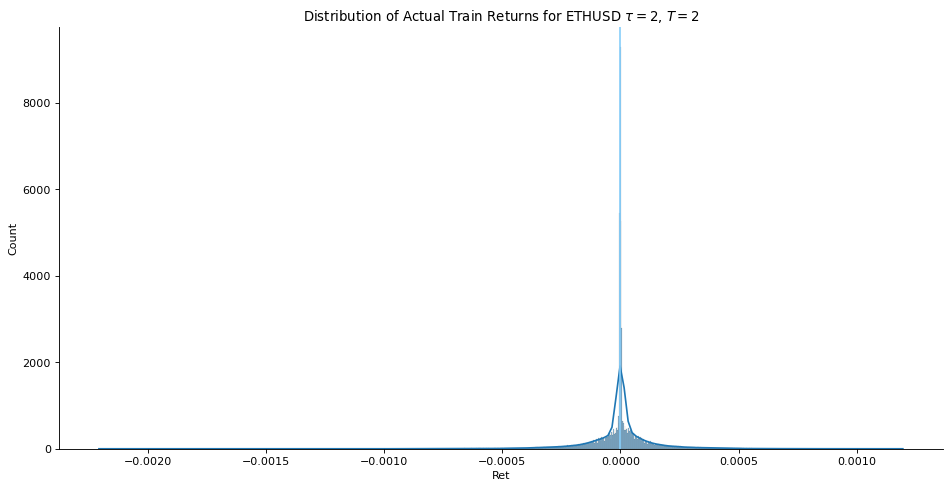

In [835]:
plot_returns(ETHUSD_train,r'ETHUSD $\tau=2$, $T=2$','Train')

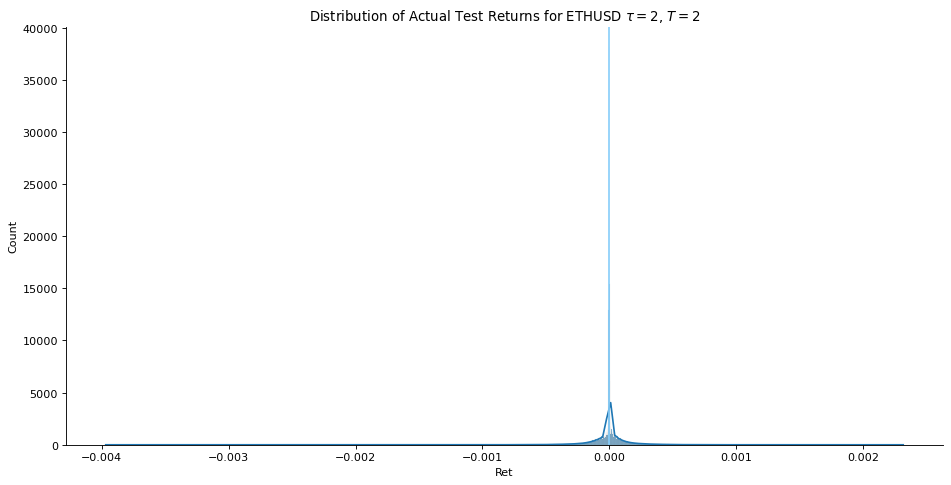

In [836]:
plot_returns(ETHUSD_test,r'ETHUSD $\tau=2$, $T=2$','Test')

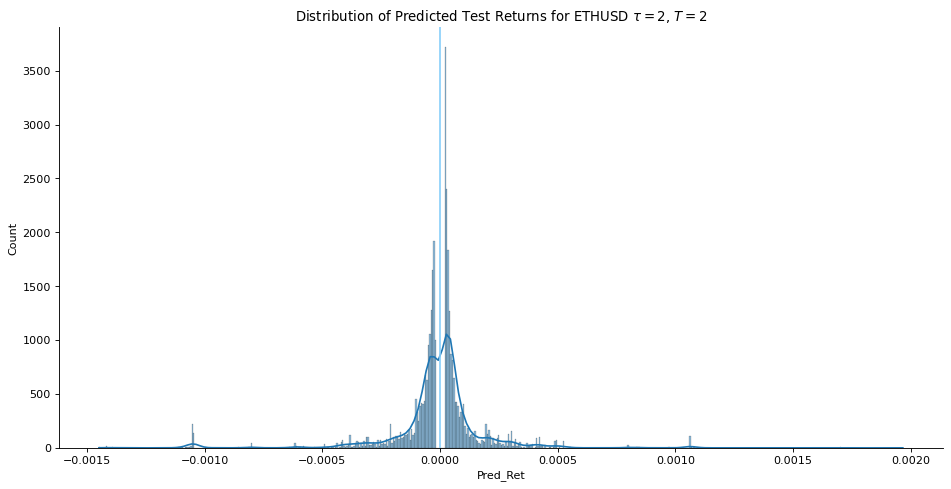

In [837]:
plot_predreturns(ETHUSD_test[(ETHUSD_test['Pred_Ret'] > 0.00002) | (ETHUSD_test['Pred_Ret'] < -0.00002)],r'ETHUSD $\tau=2$, $T=2$')

### ETHBTC

ETHBTC's best strategy has the lowest out of sample R-squared out of any of the currency pairs at 3%. It also has negative alpha, and makes barely any money in the sample strategy, with PL at $6. It appears that the high frequency tau/T combinations for this pair do not work, or are not worth the real costs that would ensue.

#### Strategy Comparison: Top/Bottom 5

The max drawdowns appear to be very low, but that is also because the number of trades and resulting PL are also very low - there is not much activity or opportunities for this pair compared to the first two.

In [773]:
ETHBTC_perf_table = evaluate(ETHBTC_trades,"ETHBTC",tau_list,T_list,strat="yes",warning_mask=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [774]:
ETHBTC_pred_table = evaluate(ETHBTC_trades,"ETHBTC",tau_list,T_list,pred="yes",warning_mask=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [838]:
ETHBTC_perf_table.sort_values(r'OOS $R^2$',ascending=False).head()

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,PL_LTD,Alpha,Beta,$R^2$,OOS $R^2$
ETHBTC_tau_30_T_60,0.0000000,0.0000000,0.1368764,0.1333008,-0.0000000,0.0000000,-0.0000001,6.2948222,-0.0000087,-0.0000076,0.0348447,0.0323256
ETHBTC_tau_60_T_60,0.0000000,0.0000000,0.1170587,0.0977391,-0.0000000,0.0000000,-0.0000002,6.2117518,-0.0000095,-0.0000053,0.0288517,0.0310786
ETHBTC_tau_1_T_30,0.0000000,0.0000000,0.1309825,0.0433185,-0.0000000,0.0000000,-0.0000001,3.0729855,-0.0000030,-0.0000124,0.0361817,0.0225878
ETHBTC_tau_1_T_60,0.0000000,0.0000000,0.1175695,0.0270557,-0.0000000,0.0000000,-0.0000002,3.4802251,-0.0000050,-0.0000135,0.0308931,0.0209403
ETHBTC_tau_1_T_10,0.0000000,0.0000000,0.1292134,0.0611415,-0.0000000,0.0000000,-0.0000000,2.4872902,-0.0000040,-0.0000102,0.0258779,0.0198121


In [839]:
ETHBTC_perf_table.sort_values(r'OOS $R^2$',ascending=False).tail()

,Mean,Vol,Sharpe,Sortino,Min,Max,Max Drawdown,PL_LTD,Alpha,Beta,$R^2$,OOS $R^2$
ETHBTC_tau_10_T_2,0.0000000,0.0000000,0.0833881,0.0462821,-0.0000000,0.0000000,-0.0000000,1.8474956,0.0000217,-0.0000064,0.0111948,-0.0093025
ETHBTC_tau_60_T_2,0.0000000,0.0000000,0.0566910,0.0379851,-0.0000000,0.0000000,-0.0000001,1.7173743,0.0000200,-0.0000029,0.0074502,-0.0109795
ETHBTC_tau_60_T_1,0.0000000,0.0000000,0.0646440,0.0405505,-0.0000000,0.0000000,-0.0000001,2.1622986,0.0000542,-0.0000034,0.0068940,-0.0200092
ETHBTC_tau_30_T_1,0.0000000,0.0000000,0.0718685,0.0435755,-0.0000000,0.0000000,-0.0000001,2.1045008,0.0000545,-0.0000049,0.0083893,-0.0234013
ETHBTC_tau_10_T_1,0.0000000,0.0000000,0.0822436,0.0386911,-0.0000000,0.0000000,-0.0000000,2.0172002,0.0000560,-0.0000079,0.0110372,-0.0237398


##### Best/Worst Intervals

The percentage of predicted returns over $j$ is fairly consistent with the other strategies - averaging around 3%, and there is less skew/kurtosis than the other pairs as well. It appears that the return structure is much more normally distributed than the other pairs. However, the low R-squared makes it hard to guage the predictability of the returns.

In [840]:
ETHBTC_pred_table.sort_values(r'OOS $R^2$',ascending=False).head()

,Act $\sigma$,Pred $\sigma$,Pred > j_h %,Pred < j_l %,j_h,j_l,Act_Skew,Act_Kurtosis,Pred Neg. Miss Rate %,Alpha,Beta,$R^2$,OOS $R^2$
ETHBTC_tau_30_T_60,0.0003633,0.0001294,0.0461903,0.0471446,0.0001229,-0.0001360,-1.3989205,10.6978805,0.4345320,-0.0000087,-0.0000076,0.0348447,0.0323256
ETHBTC_tau_60_T_60,0.0003633,0.0001152,0.0611544,0.0593984,0.0001095,-0.0001210,-1.3989205,10.6978805,0.4452970,-0.0000095,-0.0000053,0.0288517,0.0310786
ETHBTC_tau_1_T_30,0.0002982,0.0000969,0.0241258,0.0253092,0.0000941,-0.0000998,-0.7228796,4.9827670,0.3876164,-0.0000030,-0.0000124,0.0361817,0.0225878
ETHBTC_tau_1_T_60,0.0003633,0.0001051,0.0241258,0.0253092,0.0001003,-0.0001100,-1.3989205,10.6978805,0.4335013,-0.0000050,-0.0000135,0.0308931,0.0209403
ETHBTC_tau_1_T_10,0.0002687,0.0000800,0.0241258,0.0253092,0.0000760,-0.0000839,-0.1300695,1.7855282,0.3183692,-0.0000040,-0.0000102,0.0258779,0.0198121


In [841]:
ETHBTC_pred_table.sort_values(r'OOS $R^2$',ascending=False).tail()

,Act $\sigma$,Pred $\sigma$,Pred > j_h %,Pred < j_l %,j_h,j_l,Act_Skew,Act_Kurtosis,Pred Neg. Miss Rate %,Alpha,Beta,$R^2$,OOS $R^2$
ETHBTC_tau_10_T_2,0.0003233,0.0000758,0.0334020,0.0332112,0.0000982,-0.0000535,0.0660750,2.2783843,0.3023744,0.0000217,-0.0000064,0.0111948,-0.0093025
ETHBTC_tau_60_T_2,0.0003233,0.0000625,0.0611544,0.0593984,0.0000846,-0.0000404,0.0660750,2.2783843,0.3114216,0.0000200,-0.0000029,0.0074502,-0.0109795
ETHBTC_tau_60_T_1,0.0003820,0.0000743,0.0611544,0.0593984,0.0001309,-0.0000176,0.7313815,8.0895185,0.3175294,0.0000542,-0.0000034,0.0068940,-0.0200092
ETHBTC_tau_30_T_1,0.0003820,0.0000837,0.0461903,0.0471446,0.0001397,-0.0000278,0.7313815,8.0895185,0.3149336,0.0000545,-0.0000049,0.0083893,-0.0234013
ETHBTC_tau_10_T_1,0.0003820,0.0000929,0.0334020,0.0332112,0.0001498,-0.0000361,0.7313815,8.0895185,0.3108872,0.0000560,-0.0000079,0.0110372,-0.0237398


#### Optimization of $j$: Top 5

In [777]:
ETHBTC_maxj = optimal_j(ETHBTC_trades,BTCUSD_book,'ETHBTC',30,60)

  0%|          | 0/9 [00:00<?, ?it/s]

In [778]:
ETHBTC_maxj = ETHBTC_maxj.T
ETHBTC_maxj['Sharpe_diff'] = ETHBTC_maxj['Sharpe'].diff()

In [779]:
ETHBTC_maxj.sort_values('Sharpe',ascending=False)[:5]

,PL_LTD,Sharpe,Sharpe_diff
5e-05,10.6317070,0.1814539,0.0193218
0.0,15.2458400,0.1621321,NaN
0.0001,7.5505820,0.1509944,-0.0304594
0.00015000000000000001,5.8023585,0.1307999,-0.0201946
0.0002,4.6326678,0.1196166,-0.0111833


##### Distribution of Returns for the Best Strategy

The visual representation of the predicted returns show how it is much more normally distributed than for the other currency pairs.

In [783]:
ETHBTC_train, ETHBTC_test = train_tau([ETHBTC_trades],[BTCUSD_book],'ETHBTC',30,60,warnings="False")

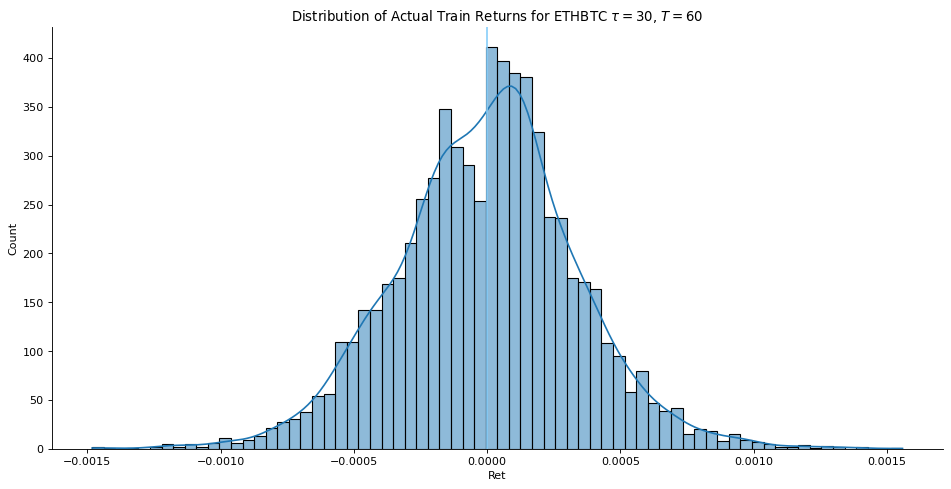

In [825]:
plot_returns(ETHBTC_train,r'ETHBTC $\tau=30$, $T=60$','Train')

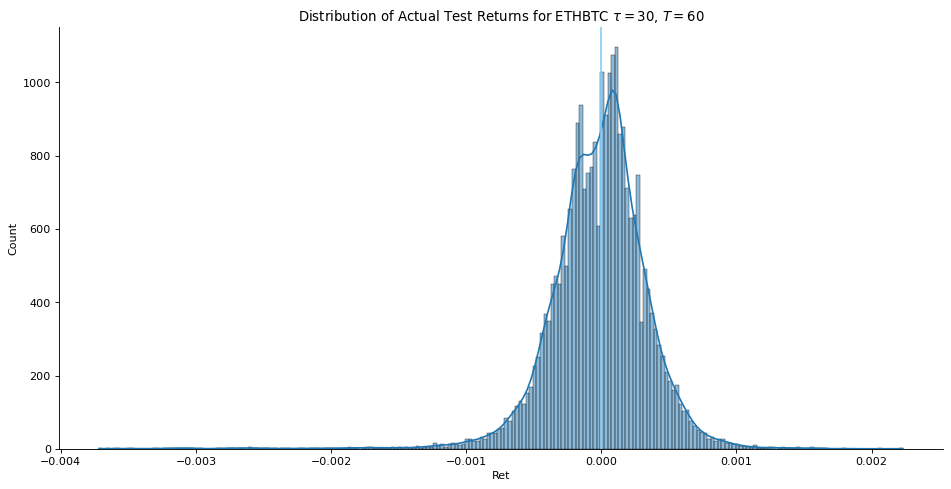

In [826]:
plot_returns(ETHBTC_test,r'ETHBTC $\tau=30$, $T=60$','Test')

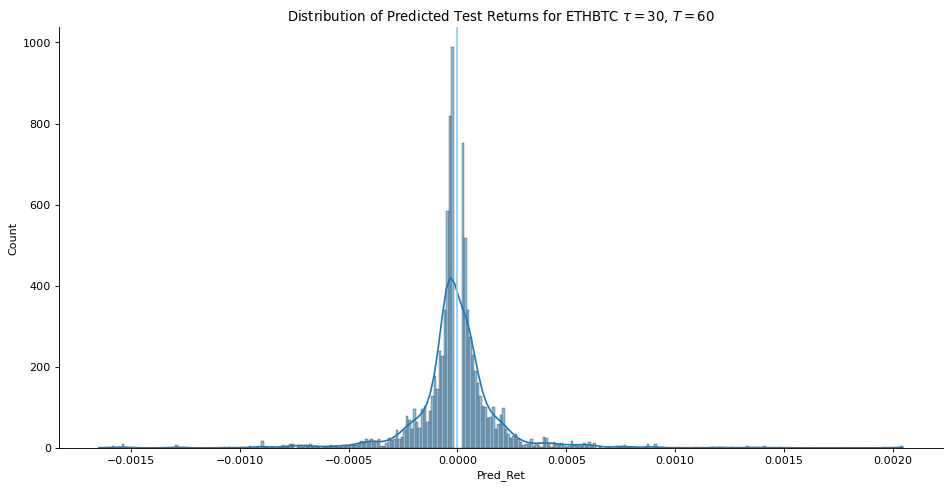

In [827]:
plot_predreturns(ETHBTC_test[(ETHBTC_test['Pred_Ret'] > 0.00002) | (ETHBTC_test['Pred_Ret'] < -0.00002)],r'ETHBTC $\tau=30$, $T=60$')

## Conclusion

The optimization of $\tau$ and $T$ are key in finding trading opportunities. When running for 16 combinations of the two variables on three currency pairs, there is a significant dispersion in the predictive power of flow for returns. When optimized, the analysis above shows that some pairs result in beta values with high $R^2$ and Out of Sample $R^2$. For example, the best performing strategy for BTCUSD where of $\tau = 30$ and $T = 60$ had an $R^2$ of 25% and Out of Sample $R^2$ of 28% - both very high considering the high frequency data being analyzed. Variability is explained 1 in 4 times. This, along with some other opportunities in BTCUSD as well as ETHUSD, have large potential to be trading opportunities - and the simply "benchmark" trading strategy used in the analysis backs this up, with high PL and Sharpe ratios.

In terms of optimization of $j$, there are many factors in considering what constitutes the best $j$. This is highly dependent on trading frequency, capital limits, and lag limits. Given the high frequency of the data, it is also difficult to ascertain one single number for it, and standard deviation-related ranges can be helpful in determining what is a good entry point at any given time. The analysis above suggests that generally speaking, lower $j$ values are ideal in perfectly efficient capital markets, and only the ETHBTC pair contradicted this assumption - though very slightly. This particular pair suggest $j$ is optimized at half a bp in terms of Sharpe ratio. For $j$, there may be a broader set of practical applications if one focuses on the decay in the Sharpe ratio upon moving $j$ away from zero. The decay is most extreme for ETHUSD, and least for BTCUSD. This may have to do with liquidity - the more trades are, the more "ideal" profit-taking can be done in perfect capital markets. However in reality, this relationship will not be as strong given the costs in this boundary, and many of the tight trades around small $j$s will not be executable.

In conclusion, based on the analysis, it is best to execute a trading strategy for BTCUSD, using $\tau=30, T=60$. The OOS R-squared is the highest, the market is the most liquid, and the returns in the simulated strategy were the highest. $j$ would need to be further optimized depending on the real-world constraints and costs. Below is summarized the major stats and graphical representations of the strategy.